The primary goal of the International Consortium for Brain Mapping (ICBM) is to develop a probabilistic reference system for the human brain. The implementation of a data sharing space allows laboratories worldwide to make their own contribution to the ICBM evolving atlas.

# Setup and Libraries

In [190]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
import nibabel as nib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ants

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and json for participants

In [191]:
DATASET_DIR = Path("/home/falconnier/Documents/dataset desktop/OMEGA/omega_data/")
# DATASET_DIR = Path("/home/falconnier/Documents/dataset desktop/SCSDB")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/RocklandSample/")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/SALD/RawData_BIDS/")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/SLIM/RawData/")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/BGSP/")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/NIMH/")
# DATASET_DIR = Path("/home/falconnier/Documents/datasets laptop/Paingen_placebo/")
# DATASET_DIR = Path(
#     "/home/falconnier/Documents/datasets laptop/conp-dataset/projects/AdolescentBrainDevelopment/"
# )
# DATASET_DIR = Path(
#     "/home/falconnier/Documents/datasets laptop/conp-dataset/projects/preventad-open-bids/BIDS_dataset/"
# )  # participants link broken, need to download it again


In [192]:
assert DATASET_DIR.exists(), f"Dataset directory {DATASET_DIR} does not exist."
readme_path = DATASET_DIR / "README.md"
descriptions_path = DATASET_DIR / "dataset_description.json"
json_path = DATASET_DIR / "participants.json"
tsv_path = DATASET_DIR / "participants.tsv"

AssertionError: Dataset directory /home/falconnier/Documents/dataset desktop/OMEGA/omega_data does not exist.

In [ ]:
# Check for README files in the dataset root and print their contents if found

if readme_path.exists():
    print(readme_path.read_text(encoding="utf-8"))
else:
    display(f"No README file found at {DATASET_DIR}.")

if descriptions_path.exists():
    print(descriptions_path.read_text(encoding="utf-8"))
else:
    display(f"No description file found at {DATASET_DIR}.")

'No README file found at /home/falconnier/Documents/datasets laptop/conp-dataset/projects/preventad-open-bids/BIDS_dataset.'

{
   "BIDSVersion" : "1.1.1 & BEP0001",
   "LORISScriptVersion" : "0.1",
   "LORISReleaseVersion" : "20.1.0",
   "Authors" : [
      "StoP-AD Center - Douglas Mental Health University Institute"
   ],
   "Name" : "PREVENT-AD_open_release_bids",
   "HowToAcknowledge" : "I will state the source of data and cite the primary publication of PREVENT-AD in\nthe methods section of my manuscripts by including language similar to the\nfollowing: 'Data used in preparation of this article were obtained from the\nPre-symptomatic Evaluation of Novel or Experimental Treatments for Alzheimer's\nDisease (PREVENT-AD) program. (Breitner et al., 2016)'.\n"
}



In [ ]:
json_path = DATASET_DIR / "participants.json"

# Safely open and load the JSON file if it exists
if json_path.exists():
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        # Print the JSON content (pretty-printed)
        print(json.dumps(data, indent=4))
    except Exception as e:
        print(f"Failed to load JSON file {json_path}: {e}")
        data = {}
else:
    print(f"No JSON file found at {json_path}. Continuing without JSON.")
    data = {}

{
    "handedness_interpretation": {
        "Description": "participant's handedness interpretation from the Edinburgh Handedness Inventory",
        "Levels": {
            "Ambidextrous": "Ambidextrous",
            "Left-handed": "Left-handed",
            "Right-handed": "Right-handed"
        }
    },
    "test_language": {
        "Description": "test issued in (language)",
        "Levels": {
            "English": "English",
            "French": "French"
        }
    },
    "handedness_score": {
        "Description": "participant's handedness score from the Edinburgh Handedness Inventory"
    },
    "sex": {
        "Description": "sex of the participant",
        "Levels": {
            "Male": "Male",
            "Female": "Female"
        }
    }
}


In [ ]:
if tsv_path.exists():
    print(f"TSV file found at {tsv_path}.")
    df = pd.read_csv(DATASET_DIR / "participants.tsv", sep="\t")
    print(df.columns)
else:
    print(f"No TSV file found at {tsv_path}.")

No TSV file found at /home/falconnier/Documents/datasets laptop/conp-dataset/projects/preventad-open-bids/BIDS_dataset/participants.tsv.


In [ ]:
if tsv_path.exists():
    # little adjustments
    # Convert categorical variables
    categorical_cols = [
        "participant_id",
        "sex",
        "handedness",
        "group",
        "sessions",
        "recordings",
        "anatomy",
        "questionnaires",
    ]

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype("category")

    # Replace impossible values
    # df["age"] = df["age"].replace(0, np.nan)

    df.head()


# Basic descriptions

In [ ]:
if tsv_path.exists():
    print("=== Columns in the Dataset ===")
    display(pd.DataFrame(df.columns, columns=["Column Names"]))

    print("\n=== Numeric Features Summary ===")
    display(df.describe().round(2))

    print("\n=== Categorical Features Summary ===")
    display(df.describe(include=["category", "object"]))

    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df) * 100).round(2)

    missing_df = pd.DataFrame(
        {"Missing Count": missing_count, "Missing %": missing_percent}
    ).sort_values(by="Missing Count", ascending=False)

    print("=== Missing Values by Column ===")
    display(missing_df)


# Histograms

In [ ]:
if tsv_path.exists():
    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        plt.figure(figsize=(6, 4))

        ax = sns.histplot(df[col].dropna(), bins=30, kde=False)

        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")

        for patch in ax.patches:
            height = patch.get_height()
            if height > 0:
                ax.text(
                    patch.get_x() + patch.get_width() / 2,
                    height + 0.5,
                    int(height),
                    ha="center",
                    va="bottom",
                    fontsize=8,
                )

        plt.tight_layout()
        plt.show()


In [ ]:
if tsv_path.exists():
    categorical_cols = df.select_dtypes(include=["category", "object"]).columns

    for col in categorical_cols:
        plt.figure(figsize=(6, 4))

        counts = df[col].value_counts(dropna=False)
        total = counts.sum()
        order = counts.index

        ax = sns.countplot(y=col, data=df, order=order)

        for p, category in zip(ax.patches, order):
            count = counts[category]
            percent = 100 * count / total

            ax.text(
                p.get_width() + 0.5,
                p.get_y() + p.get_height() / 2,
                f"{count} ({percent:.1f}%)",
                va="center",
            )

        plt.title(f"Value Counts for {col}")
        plt.xlabel("Count")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


In [ ]:
if tsv_path.exists():
    if "sessions" in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(
            x="sessions", data=df, order=sorted(df["sessions"].dropna().unique())
        )
        plt.title("Number of Sessions per Participant")
        plt.xlabel("Sessions")
        plt.ylabel("Number of Participants")
        plt.tight_layout()
        plt.show()
    if "recordings" in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(
            x="recordings", data=df, order=sorted(df["recordings"].dropna().unique())
        )
        plt.title("Number of Recordings per Participant")
        plt.xlabel("Recordings")
        plt.ylabel("Number of Participants")
        plt.tight_layout()
        plt.show()


# anat analysis

Scan for nifti files

In [ ]:
anat_files = list(DATASET_DIR.rglob("anat/*T1w*.nii*"))
print(f"Found {len(anat_files)} anatomical files.")


Found 1695 anatomical files.


In [ ]:
import os
import nibabel as nib

data = []

for fpath in anat_files:
    fname = fpath.name

    # -------------------------
    # Parse BIDS filename
    # -------------------------
    parts = fname.split("_")
    sub_id = next((p.split("-")[1] for p in parts if p.startswith("sub-")), None)
    ses_id = next((p.split("-")[1] for p in parts if p.startswith("ses-")), None)
    modality = next(
        (p.replace(".nii.gz", "") for p in parts if p.endswith(".nii.gz")), None
    )

    # Defaults (in case file is empty or broken)
    voxel_sizes = (None, None, None)
    shape = (None, None, None)
    slice_thickness = None
    z_size = None
    load_error = None

    # -------------------------
    # Check for empty file
    # -------------------------
    if fpath.stat().st_size == 0:
        load_error = "empty_file"

    else:
        try:
            img = nib.load(fpath)
            header = img.header

            voxel_sizes = header.get_zooms()
            shape = img.shape

            if len(voxel_sizes) >= 3:
                slice_thickness = voxel_sizes[2]
            if len(shape) >= 3:
                z_size = shape[2]

        except Exception as e:
            load_error = str(e)

    # -------------------------
    # Store metadata
    # -------------------------
    data.append(
        {
            "participant_id": sub_id,
            "session_id": ses_id,
            "modality": modality,
            "file_path": str(fpath),
            "voxel_size_x": voxel_sizes[0],
            "voxel_size_y": voxel_sizes[1],
            "voxel_size_z": voxel_sizes[2] if len(voxel_sizes) >= 3 else None,
            "slice_thickness": slice_thickness,
            "x_dim": shape[0],
            "y_dim": shape[1],
            "z_dim": z_size,
            "load_error": load_error,  # ← QC column
        }
    )


FileNotFoundError: [Errno 2] No such file or directory: '/home/falconnier/Documents/datasets laptop/conp-dataset/projects/preventad-open-bids/BIDS_dataset/sub-5443870/ses-NAPEN00/anat/sub-5443870_ses-NAPEN00_run-001_T1w.nii.gz'

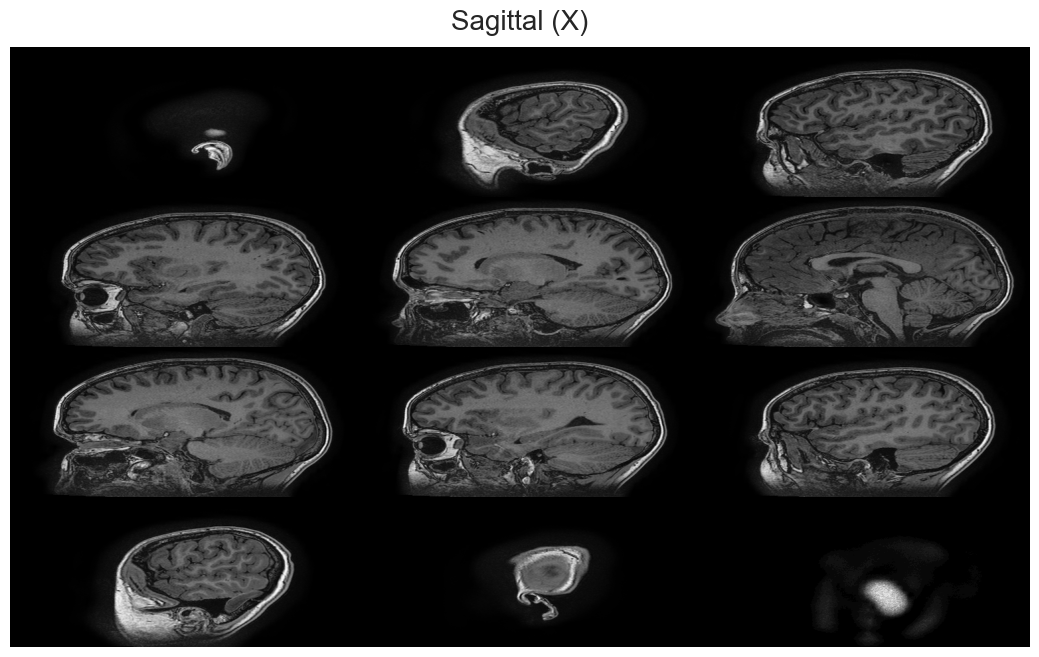

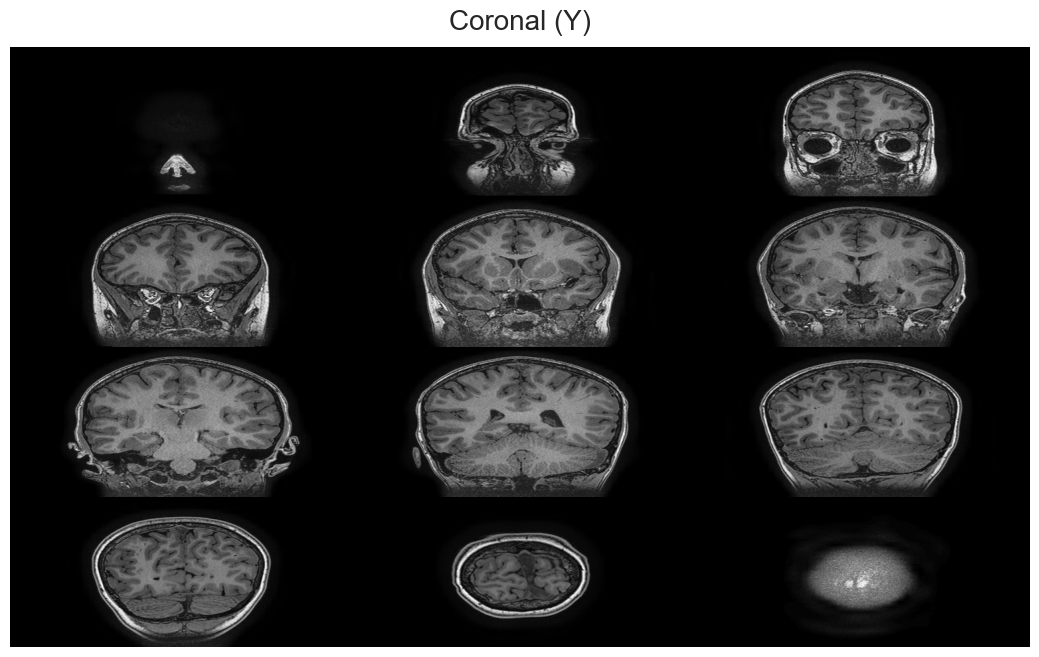

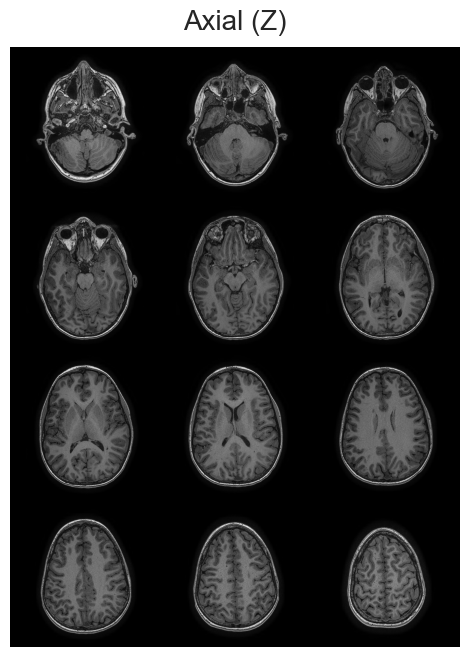

/home/falconnier/Documents/datasets laptop/conp-dataset/projects/AdolescentBrainDevelopment/sub-10020/ses-01/anat/sub-10020_ses-01_rec-PURE_T1w.nii.gz


In [ ]:
img = ants.image_read(str(fpath))

# Plot slices along each axis
ants.plot(img, axis=0, title="Sagittal (X)")
ants.plot(img, axis=1, title="Coronal (Y)")
ants.plot(img, axis=2, title="Axial (Z)")
print(fpath)

In [ ]:
df_anat = pd.DataFrame(data)
print(f"Summary dataframe shape: {df_anat.shape}")
print("\n========FILES THAT ARE EMPTY===================")
print(
    df_anat[df_anat["file_path"].apply(lambda p: Path(p).stat().st_size == 0)][
        ["participant_id", "session_id"]
    ]
)
print("\n===============================================")
df_anat.head()


Summary dataframe shape: (226, 12)

========FILES THAT ARE EMPTY===================
Empty DataFrame
Columns: [participant_id, session_id]
Index: []



,participant_id,session_id,modality,file_path,voxel_size_x,voxel_size_y,voxel_size_z,slice_thickness,x_dim,y_dim,z_dim,load_error
0,10013,02,T1w,/home/falconnier/Documents/datasets laptop/con...,0.4688,0.4688,0.800105,0.800105,512,512,226,None
1,10013,02,T1w,/home/falconnier/Documents/datasets laptop/con...,0.4688,0.4688,0.800105,0.800105,512,512,226,None
2,10013,01,T1w,/home/falconnier/Documents/datasets laptop/con...,0.4688,0.4688,0.799802,0.799802,512,512,226,None
3,10013,01,T1w,/home/falconnier/Documents/datasets laptop/con...,0.4688,0.4688,0.799802,0.799802,512,512,226,None
4,10054,01,T1w,/home/falconnier/Documents/datasets laptop/con...,0.4688,0.4688,0.800000,0.800000,512,512,226,None


In [ ]:
# Count of modalities
print("Modality Counts:")
print(df_anat["modality"].value_counts())

# Slice thickness statistics
print("\nSlice Thickness Statistics:")
print(df_anat["slice_thickness"].describe().round(2))

# Z dimension statistics
print("\nZ Dimension Statistics:")
print(df_anat["z_dim"].describe())

# sessions
print("\nZ Sessions Statistics:")
print(df_anat["session_id"].describe())


Modality Counts:
modality
T1w    226
Name: count, dtype: int64

Slice Thickness Statistics:
count    226.0
mean       0.8
std        0.0
min        0.8
25%        0.8
50%        0.8
75%        0.8
max        0.8
Name: slice_thickness, dtype: float64

Z Dimension Statistics:
count    226.0
mean     226.0
std        0.0
min      226.0
25%      226.0
50%      226.0
75%      226.0
max      226.0
Name: z_dim, dtype: float64

Z Sessions Statistics:
count     226
unique      3
top        01
freq      116
Name: session_id, dtype: object


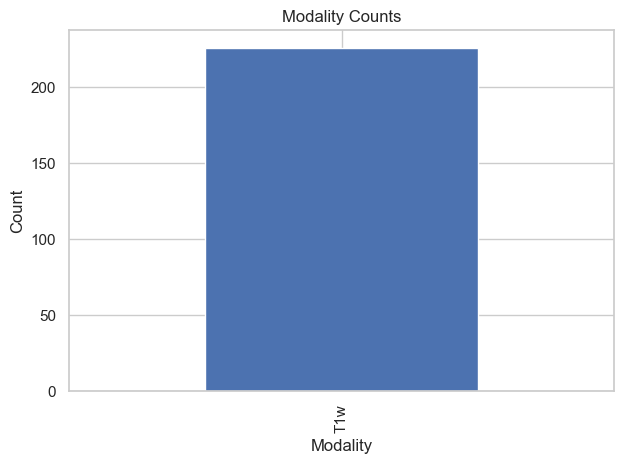

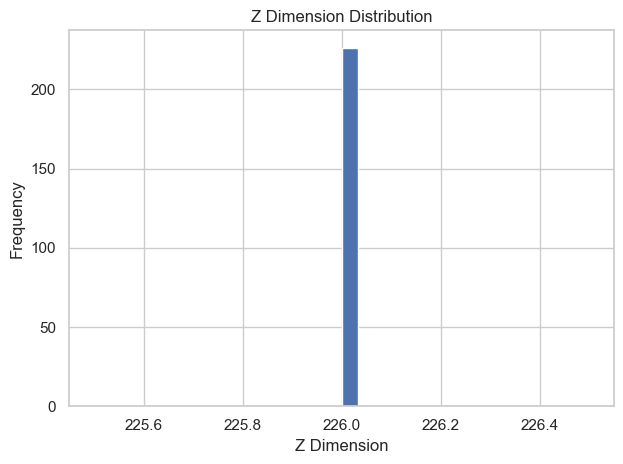

In [ ]:
# -------------------------
# Modality counts (bar plot)
# -------------------------
df_anat["modality"].value_counts().plot(kind="bar")
plt.title("Modality Counts")
plt.xlabel("Modality")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# # -------------------------
# # Slice thickness histogram
# # -------------------------
# df_anat["slice_thickness"].dropna().plot(kind="hist", bins=30)
# plt.title("Slice Thickness Distribution")
# plt.xlabel("Slice Thickness")
# plt.ylabel("Frequency")
# plt.tight_layout()
# plt.show()

# -------------------------
# Z dimension histogram
# -------------------------
df_anat["z_dim"].dropna().plot(kind="hist", bins=30)
plt.title("Z Dimension Distribution")
plt.xlabel("Z Dimension")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

In [ ]:
scans_per_subject_visit = (
    df_anat.groupby(["participant_id", "session_id"], observed=True)
    .size()
    .reset_index(name="n_scans")
)
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()


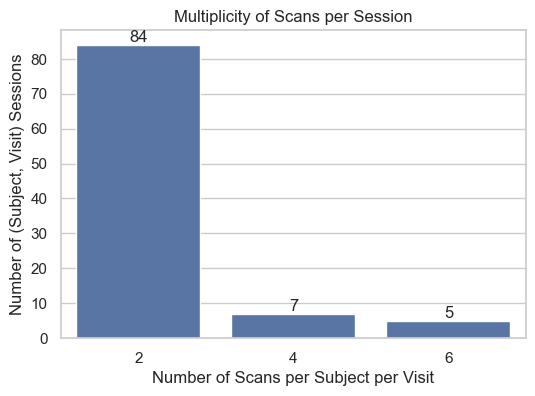

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()


# Longitudinal analysis

In [ ]:
if "session_id" in df_anat.columns:
    df_anat["session_id"].unique()

Longitudinal Coverage per Subject (Scheduled Visits):


count    51.000000
mean      1.882353
std       0.711254
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: session_id, dtype: float64

/tmp/ipykernel_1164160/3831042861.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


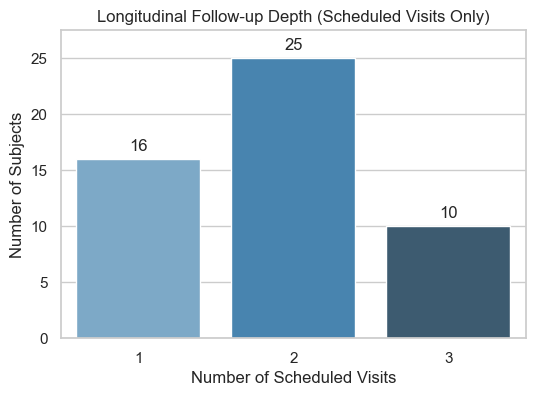

In [ ]:
if "session_id" in df_anat.columns:
    visits_per_subject = (
        df_anat.groupby("participant_id", observed=True)["session_id"]
        .nunique()
        .sort_values(ascending=False)
    )

    # Summary statistics
    summary_stats = visits_per_subject.describe()
    print("Longitudinal Coverage per Subject (Scheduled Visits):")
    display(summary_stats)

    # -------------------------------
    # Plot barplot with counts on top
    # -------------------------------
    # Count how many subjects have each number of visits
    visit_counts = visits_per_subject.value_counts().sort_index()

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

    # Annotate each bar with the count
    for i, v in enumerate(visit_counts.values):
        ax.text(i, v + 0.5, str(v), ha="center", va="bottom")

    plt.xlabel("Number of Scheduled Visits")
    plt.ylabel("Number of Subjects")
    plt.title("Longitudinal Follow-up Depth (Scheduled Visits Only)")
    plt.xticks(range(len(visit_counts.index)), visit_counts.index)
    plt.ylim(0, visit_counts.values.max() * 1.1)  # Add some space for annotations
    plt.show()

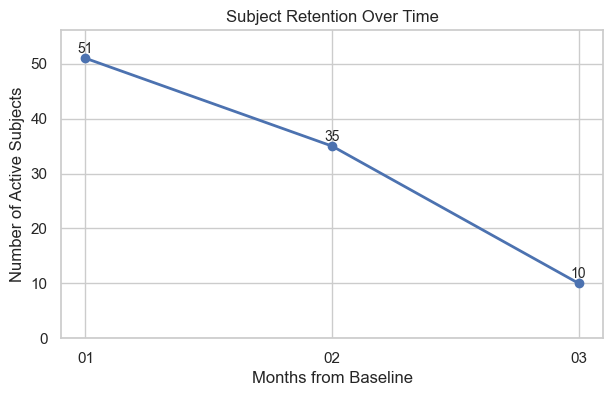

/tmp/ipykernel_1164160/137274021.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")


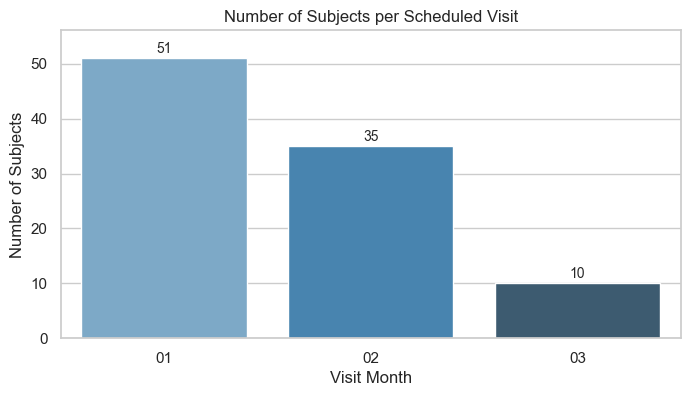

In [ ]:
if "session_id" in df_anat.columns:
    # Compute retention
    # the number of unique subjects (Subject ID) present at each scheduled visit month (Visit_Months)
    retention = (
        df_anat.groupby("session_id", observed=True)["participant_id"]
        .nunique()
        .sort_index()
    )

    # -----------------------------
    # Line plot with exact numbers
    # -----------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(retention.index, retention.values, marker="o", linewidth=2)

    # Annotate each point with the exact number
    for x, y in zip(retention.index, retention.values):
        plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=10)

    plt.xlabel("Months from Baseline")
    plt.ylabel("Number of Active Subjects")
    plt.title("Subject Retention Over Time")
    plt.grid(True)
    plt.ylim(0, retention.values.max() * 1.1)
    plt.show()

    # -----------------------------
    # Bar plot with exact numbers
    # -----------------------------
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")

    # Annotate each bar with the exact number
    for i, v in enumerate(retention.values):
        ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

    plt.xlabel("Visit Month")
    plt.ylabel("Number of Subjects")
    plt.title("Number of Subjects per Scheduled Visit")
    plt.ylim(0, retention.values.max() * 1.1)
    plt.show()